In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from qiskit import *
from qiskit.tools.visualization import plot_histogram
import math

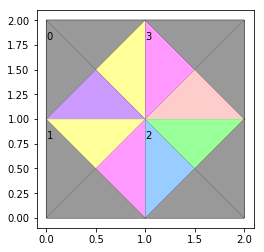

In [60]:
def cplot(current_qubits, prb, qubo_prb):
    num = 2
           #グレー    
    cmap=['#999999','#FFFF99','#CC99FF','#FF99FF','#99FF99','#99CCFF','#FFCCCC']
    fig = plt.figure()
    ax = plt.axes()
    #ax = fig.add_subplot(111)
    pcs = []
    for item in current_qubits:
        #print(item)
        #print(qubo_prb[item][0], qubo_prb[item][1])
        #print(prb[qubo_prb[item][0]][qubo_prb[item][1]])
        pcs.append(prb[qubo_prb[item][0]][qubo_prb[item][1]])
    #print("pcs:", pcs)
    for i in range(num*num):
        x = i%num
        #y = 5-i//num
        y = 1-i//num
        tri = plt.Polygon(((x,y),(x,y+1),(x+1/2,y+1/2)),ec='#000000', fill=False)
        ax.add_patch(tri)
        tri = plt.Polygon(((x,y+1),(x+1,y+1),(x+1/2,y+1/2)),ec='#000000', fill=False)
        ax.add_patch(tri)
        tri = plt.Polygon(((x+1,y),(x+1,y+1),(x+1/2,y+1/2)),ec='#000000', fill=False)
        ax.add_patch(tri)
        tri = plt.Polygon(((x,y),(x+1,y),(x+1/2,y+1/2)),ec='#000000', fill=False)
        ax.add_patch(tri)

    tmp=[]  #同じ場所にあるピース発見用
    for i in range(len(pcs)):
        location = pcs[i][0]
        lcf = 0
        if len(np.where(np.array(tmp)==location)[0])>0: lcf = 1
        x = location%num
        y = 1-location//num
        for j in range(1, len(pcs[i])):
            if lcf==0: cc = cmap[pcs[i][j]]
            else: cc='#FF0000'
            if j==1:
                tri = plt.Polygon(((x,y),(x,y+1),(x+1/2,y+1/2)),fc=cc, fill=True)
            if j==2:
                tri = plt.Polygon(((x,y+1),(x+1,y+1),(x+1/2,y+1/2)),fc=cc, fill=True)
            if j==3:
                tri = plt.Polygon(((x+1,y),(x+1,y+1),(x+1/2,y+1/2)),fc=cc, fill=True)
            if j==4:
                tri = plt.Polygon(((x,y),(x+1,y),(x+1/2,y+1/2)),fc=cc, fill=True)
            ax.add_patch(tri)
            tmp.append(location)
        ax.text(x, y+0.8,str(qubo_prb[current_qubits[i]][0]),color='black')
    plt.axis('scaled')
    ax.set_aspect('equal')
    plt.show()

In [110]:
pc = [
    [0,0,1,2],
    [0,2,3,0],
    [1,0,0,4],
    [0,0,3,4]]
p = [
    [0,0,1,2],
    [0,0,2,3],
    [0,0,4,1],
    [0,0,3,4]]

In [111]:
#回転したピースを作る
#最初の１個は固定にするので回転なし
pr = []
for i, item in enumerate(p):
    tmp = []
    for j in range(4):
        tmp2=[]
        tmp2.extend(item[j:])
        tmp2.extend(item[:j])
        f=1
        for item2 in tmp:
            #すでに同じものが含まれていたら追加しない
            if np.array_equal(tmp2, item2):
                f=0
                break
        if f==1:tmp.append(tmp2)
    pr.append(tmp)
for i in range(len(pr)):
    print("pr,i:",i, pr[i])

pr,i: 0 [[0, 0, 1, 2], [0, 1, 2, 0], [1, 2, 0, 0], [2, 0, 0, 1]]
pr,i: 1 [[0, 0, 2, 3], [0, 2, 3, 0], [2, 3, 0, 0], [3, 0, 0, 2]]
pr,i: 2 [[0, 0, 4, 1], [0, 4, 1, 0], [4, 1, 0, 0], [1, 0, 0, 4]]
pr,i: 3 [[0, 0, 3, 4], [0, 3, 4, 0], [3, 4, 0, 0], [4, 0, 0, 3]]


In [112]:
#ボードの位置
# 00 01
# 02 03

In [113]:
def add_prb(prb, prb_qubo, qubo_prb, pi, location, pri):
    tmp = [location]
    tmp.extend(pri)
    prb[pi].append(tmp)
    prb_qubo[pi].append(len(qubo_prb))
    qubo_prb.append([pi, len(prb_qubo[pi])-1])

In [114]:
#１つのピースにつき、ピースの回転×場所分のQubitを用意する。
#配列にその情報を格納しておく。
#どのピースを, どの場所に、どの回転で
#0が２つある最初のピースは左上に固定
prb=[0]*len(p)
prb_qubo=[0]*len(p)
qubo_prb=[]

#0が２つある最初のピースを左上に固定
prb[0]=[]
prb_qubo[0]=[]
#prb[0].append([0,0,0,1,2])
#prb_qubo[0].append([0])
#qubo_prb.append([0,0])
add_prb(prb, prb_qubo, qubo_prb, 0, 0, p[0])
#qubo_counter = 1
for i in range(1, len(p)):
    prb[i]=[]
    prb_qubo[i]=[]
    #counter = 0
    num0=len(np.where(np.array(p[i])==0)[0])
    for j in range(len(pr[i])):
        location = -1
        #0が２つある他のピースは、残りの角３つのどこかに配置
        if num0==2:
            #３隅をループ。zipの２番目の引数は、どこが0になるか
            #for k, gp in zip([3,12,15],[[1,2],[0,3],[2,3]]):
            for k, gp in zip([1,2,3],[[1,2],[0,3],[2,3]]):
                #ボードの隅がグレーになっているものを選ぶ
                if pr[i][j][gp[0]]==0 and pr[i][j][gp[1]]==0:
                    add_prb(prb, prb_qubo, qubo_prb, i, k, pr[i][j])
        #0が1つあるものは、辺のどこかに配置
        elif num0==1:
            #辺上のセルをループ。zipの２番目の引数は、どこが0になるか
            for k, gp in zip([1,2,4,7,8,11,13,14],[1,1,0,2,0,2,3,3]):
                #辺の部分がグレーになっているものを選ぶ
                if pr[i][j][gp]==0:
                    add_prb(prb, prb_qubo, qubo_prb, i, k, pr[i][j])
        #それ以外のは、真ん中の4つにすべての回転で配置
        else:  
            for k in [5,6,9,10]:
                add_prb(prb, prb_qubo, qubo_prb, i, k, pr[i][j])
print(prb)
print(prb_qubo)
print(qubo_prb)

[[[0, 0, 0, 1, 2]], [[2, 0, 2, 3, 0], [3, 2, 3, 0, 0], [1, 3, 0, 0, 2]], [[2, 0, 4, 1, 0], [3, 4, 1, 0, 0], [1, 1, 0, 0, 4]], [[2, 0, 3, 4, 0], [3, 3, 4, 0, 0], [1, 4, 0, 0, 3]]]
[[0], [1, 2, 3], [4, 5, 6], [7, 8, 9]]
[[0, 0], [1, 0], [1, 1], [1, 2], [2, 0], [2, 1], [2, 2], [3, 0], [3, 1], [3, 2]]


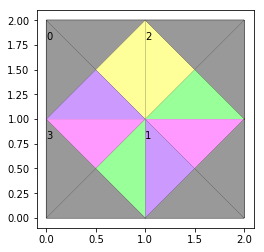

In [117]:
cplot([0,2,6,7],prb, qubo_prb)